# Kepler challenge
## preprocessing
Here I explore the data a little, putting it in the necessary format for tsfresh (which I will use for feature extraction/selection) and plot the time series data passed through a few filters. I've decided to explore giving tsfresh two time series for each star:
1. 5 step minimum filter of the detrended time series
2. 5 step mean filter of the raw time series

(the reason for the minimum filter is that the most important signal is a downward one when the exoplanets pass in front of the stars)

In some cases it feels like (1) would work best and in others (2). I guess this depends on how close the star is to us, how big the planet is, how fast its orbit is, etc. The correlation between the two time series depends on the strength of the overall trends in the flux intensities.

I used the min filters so as to get rid of bright light outliers, but to keep all relevant info on when we get dips in the intensity. This does not guard against low intensity outliers however! The 5 step filter reduced the temporal dimension of the data from 3197 time points (one every 36 mins apparently) to 639 time points. 

I experimented with different scaling and ended up using the RobustScaler, a more robust (to outliers) version of the StandardScaler. I do this scaling separately for each time series. 

As we only have 37 positives and over 5000 negatives (!), I augment the data by reversing the 37 posiitve time series (as done by Peter Greenholm in his kernel "Mystery Planet (99.8% CNN)").

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.preprocessing import RobustScaler

### Data fromatting and summarizing
Formatting: mainly turning the columns into rows - the format needed for tsfresh.

In [2]:
x_train = pd.read_csv('exoTrain.csv')
y_train = x_train.LABEL
x_train = x_train.drop('LABEL', axis=1)
y_train = y_train.replace(1, 0)
y_train = y_train.replace(2, 1)
y_train = y_train.astype('bool')
y_train.index += 1
x_train.columns = x_train.columns.str.replace('FLUX.','')
x_train = x_train.stack().rename_axis(('id', 'time')).reset_index(name='intensity')
x_train['time'] = x_train['time'].astype(str).astype(int)
x_train.loc[:,'id'] = x_train.loc[:,'id'].add(1)

print('INFO:')
print('----')
print(x_train.info())
print('')
print('HEAD:')
print('----')
print(x_train.head())
print('')
print('TAIL:')
print('----')
print(x_train.tail())
print('')
print('STATS:')
print('-----')
print(x_train.describe())

INFO:
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16263139 entries, 0 to 16263138
Data columns (total 3 columns):
id           int64
time         int64
intensity    float64
dtypes: float64(1), int64(2)
memory usage: 372.2 MB
None

HEAD:
----
   id  time  intensity
0   1     1      93.85
1   1     2      83.81
2   1     3      20.10
3   1     4     -26.98
4   1     5     -39.56

TAIL:
----
            id  time  intensity
16263134  5087  3193     -25.33
16263135  5087  3194     -41.31
16263136  5087  3195     -16.72
16263137  5087  3196     -14.09
16263138  5087  3197      27.82

STATS:
-----
                 id          time     intensity
count  1.626314e+07  1.626314e+07  1.626314e+07
mean   2.544000e+03  1.599000e+03  1.304167e+02
std    1.468490e+03  9.228944e+02  2.207221e+04
min    1.000000e+00  1.000000e+00 -2.385019e+06
25%    1.272000e+03  8.000000e+02 -1.601000e+01
50%    2.544000e+03  1.599000e+03  0.000000e+00
75%    3.816000e+03  2.398000e+03  1.705000e+01
max    

In [3]:
x_test = pd.read_csv('exoTest.csv')
y_test = x_test.LABEL
x_test = x_test.drop('LABEL', axis=1)
y_test = y_test.replace(1, 0)
y_test = y_test.replace(2, 1)
y_test = y_test.astype('bool')
y_test.index += 1
x_test.columns = x_test.columns.str.replace('FLUX.','')
x_test = x_test.stack().rename_axis(('id', 'time')).reset_index(name='intensity')
x_test['time'] = x_test['time'].astype(str).astype(int)
x_test.loc[:,'id'] = x_test.loc[:,'id'].add(1)

print('INFO:')
print('----')
print(x_test.info())
print('')
print('HEAD:')
print('----')
print(x_test.head())
print('')
print('TAIL:')
print('----')
print(x_test.tail())
print('')
print('STATS:')
print('-----')
print(x_test.describe())

INFO:
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822290 entries, 0 to 1822289
Data columns (total 3 columns):
id           int64
time         int64
intensity    float64
dtypes: float64(1), int64(2)
memory usage: 41.7 MB
None

HEAD:
----
   id  time  intensity
0   1     1     119.88
1   1     2     100.21
2   1     3      86.46
3   1     4      48.68
4   1     5      46.12

TAIL:
----
          id  time  intensity
1822285  570  3193    1354.41
1822286  570  3194    -192.81
1822287  570  3195    -277.22
1822288  570  3196     -69.63
1822289  570  3197     121.56

STATS:
-----
                 id          time     intensity
count  1.822290e+06  1.822290e+06  1.822290e+06
mean   2.855000e+02  1.599000e+03 -2.370594e+01
std    1.645446e+02  9.228946e+02  6.599854e+03
min    1.000000e+00  1.000000e+00 -2.459785e+05
25%    1.430000e+02  8.000000e+02 -1.290000e+01
50%    2.855000e+02  1.599000e+03  0.000000e+00
75%    4.280000e+02  2.398000e+03  1.498000e+01
max    5.700000e+02  3

### A few plots
Plotting the flux time series for 14 stars (including 7 which have exoplanets and 7 that don't), as well as how they look after various filtering steps.

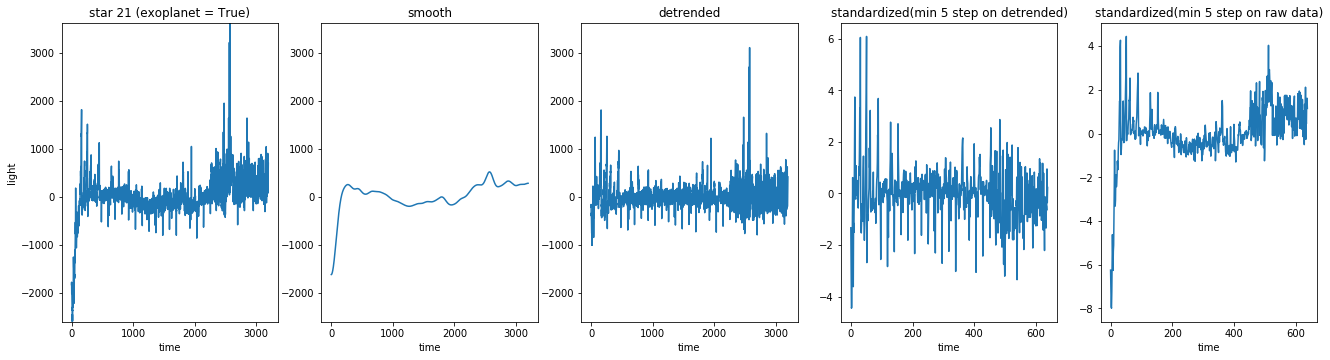

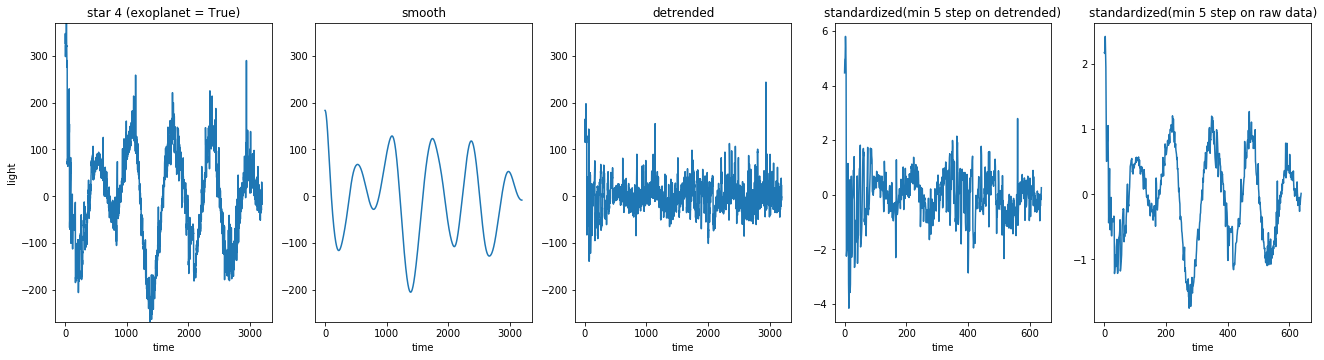

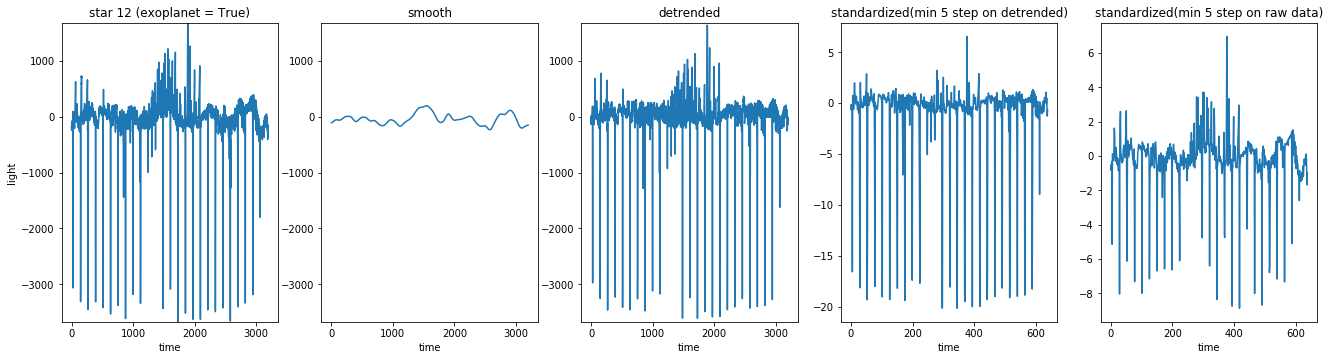

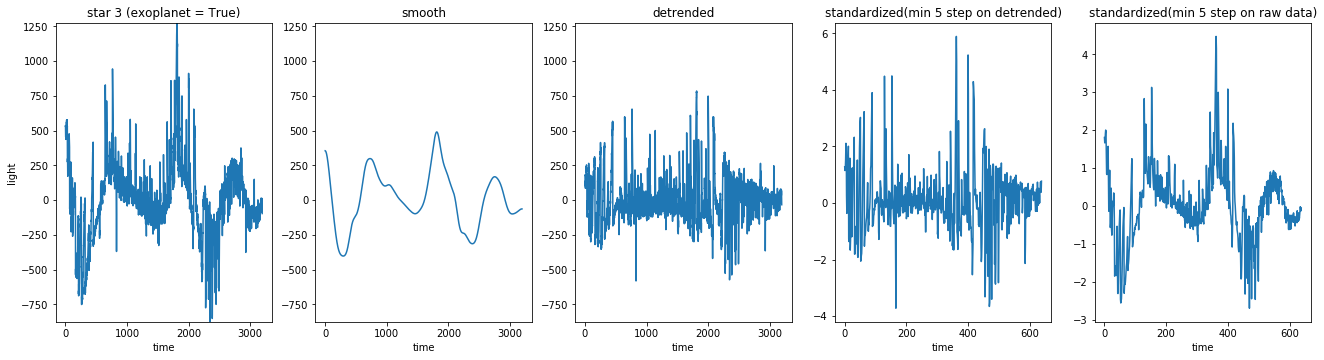

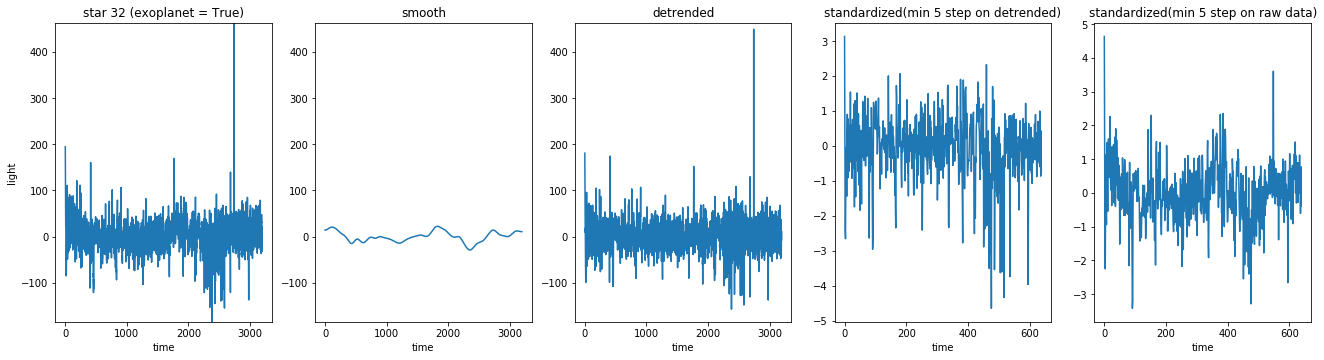

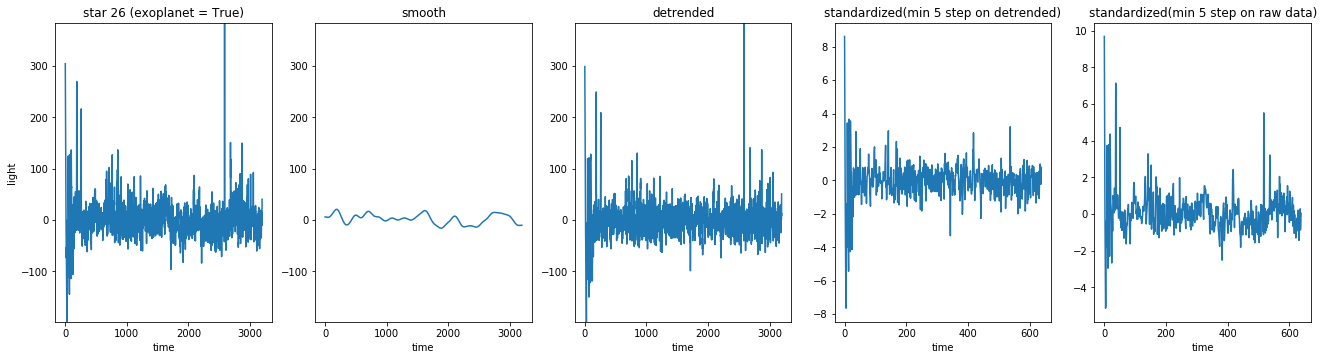

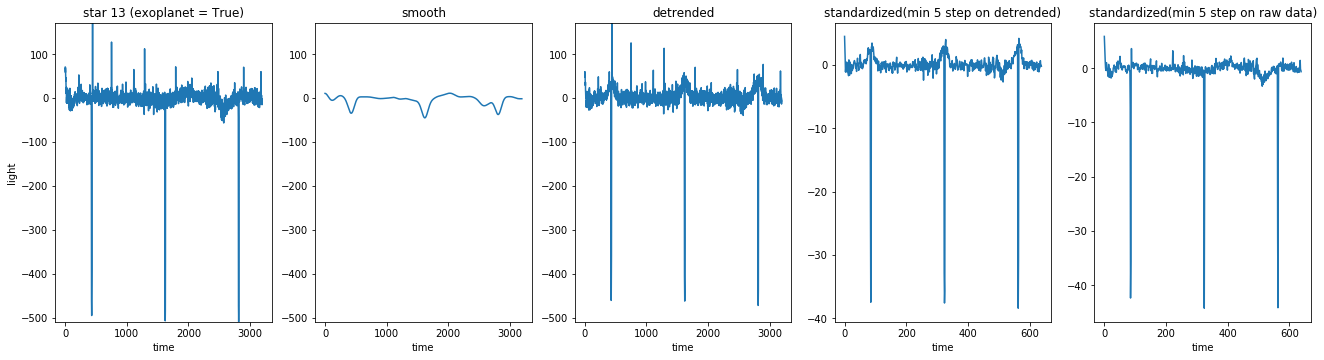

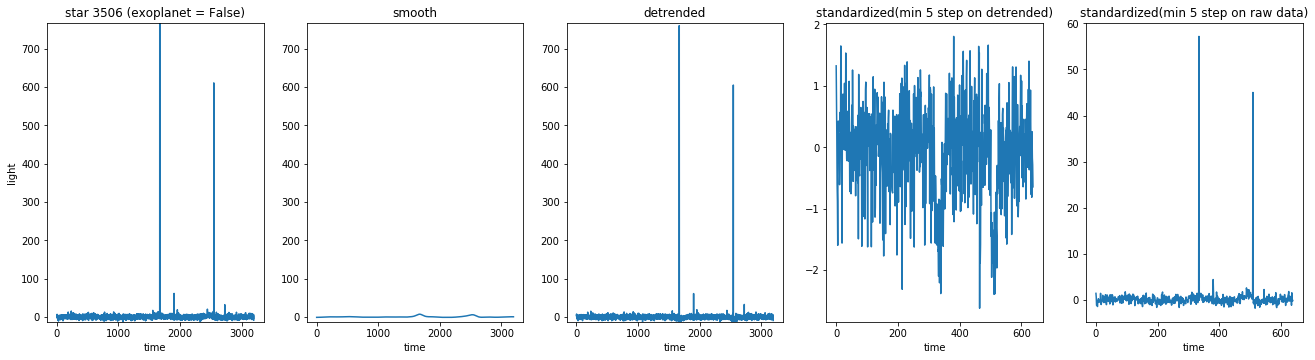

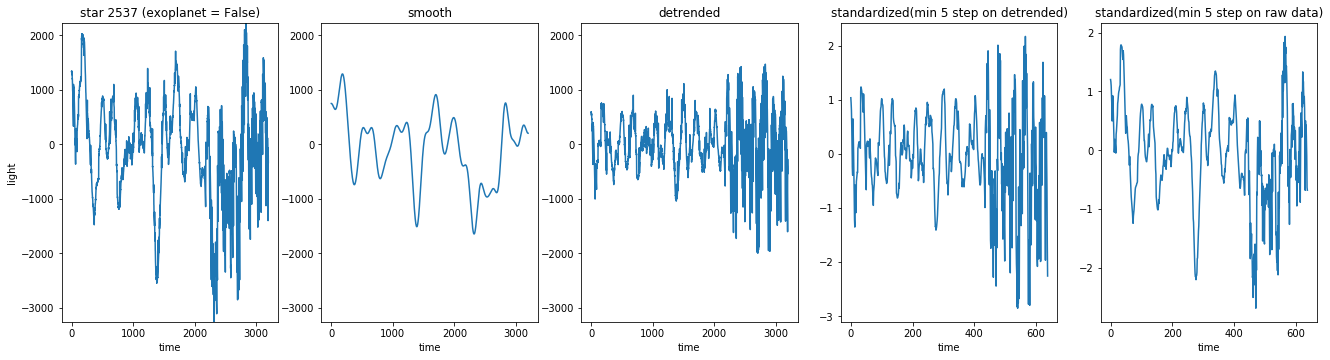

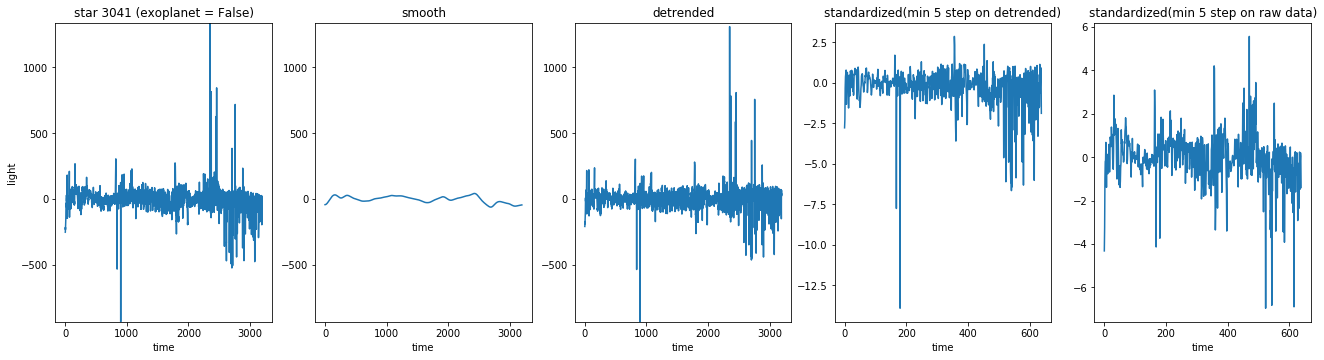

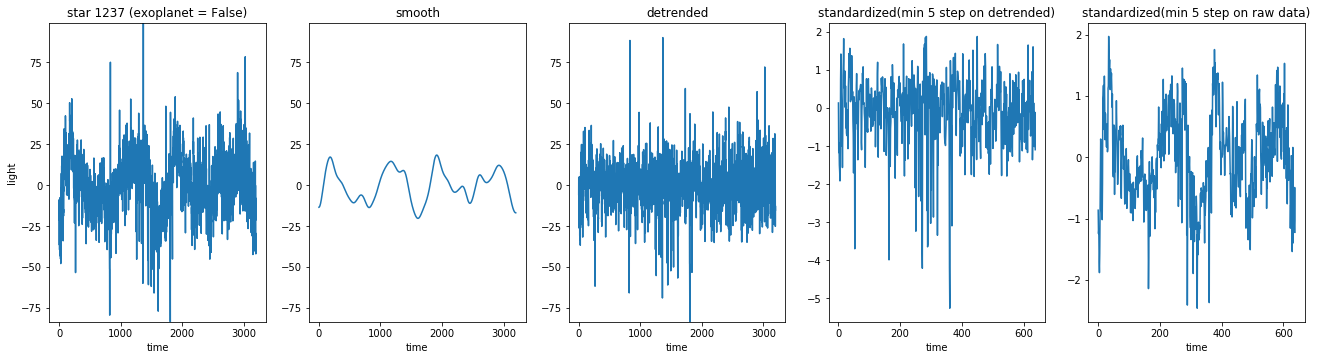

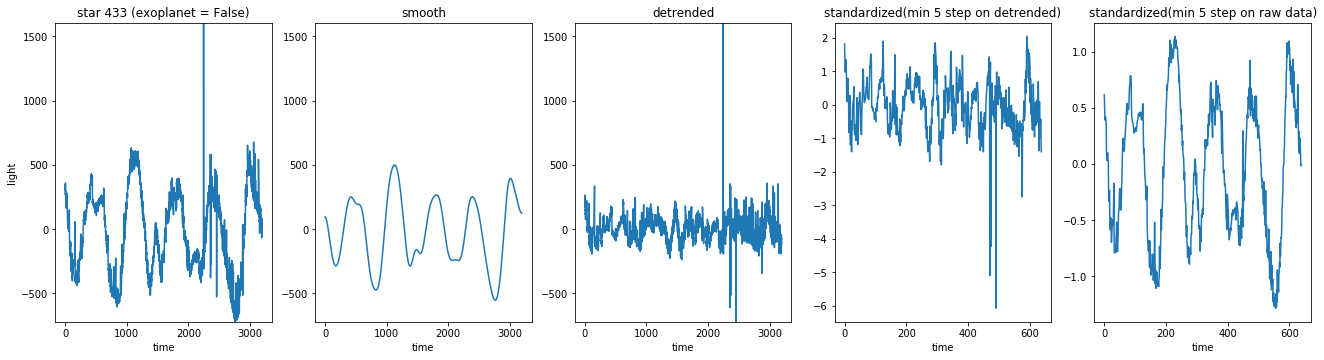

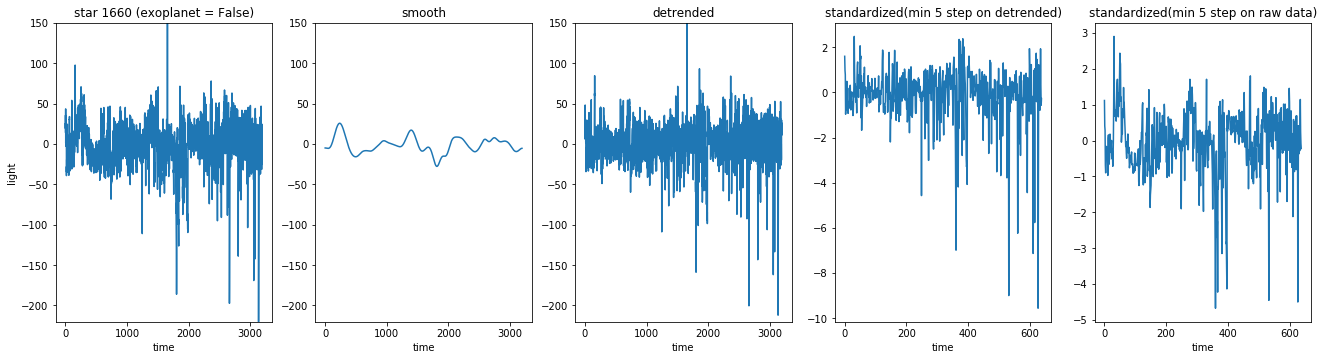

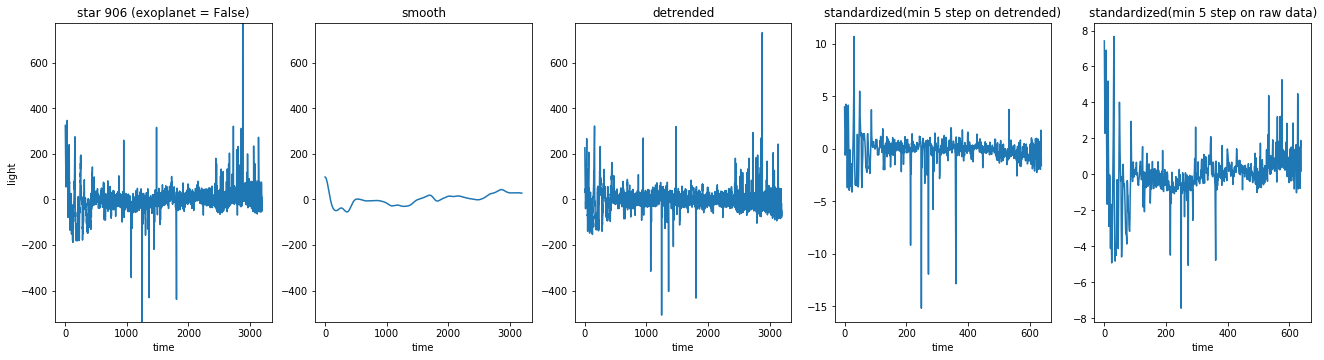

In [4]:
# detrender: modified from kernel "0.75 Precision/0.60 Recall Linear SVC" by Alexei D.
def detrender(X):
    flux1 = X
    flux2 = ndimage.filters.gaussian_filter(flux1, sigma=50)
    flux3 = flux1 - flux2
    return flux2, flux3

n_each = 7
star_exo = np.random.choice(np.arange(1, 38), n_each, replace=False)
star_noexo = np.random.choice(np.arange(38, np.max(x_train['id']) + 1), n_each, replace=False)
stars = np.concatenate((star_exo, star_noexo), axis=0)

for i in stars:
    x = x_train[x_train['id']==i]['intensity']
    fig = plt.figure(figsize=(5,5), facecolor='w')
    ax = fig.add_subplot(151)
    ax.plot(np.arange(len(x)), x)
    ax.set_ylim(np.min(x), np.max(x))
    ax.set(title='star %s (exoplanet = %s)'%(i, y_train[i]), xlabel='time', ylabel='light')
    
    x2, x3 = detrender(x)
    
    ax = fig.add_subplot(152)
    ax.plot(np.arange(len(x2)), x2)
    ax.set_ylim(np.min(x), np.max(x))
    ax.set(title='smooth', xlabel='time', ylabel='')
    
    ax = fig.add_subplot(153)
    ax.plot(np.arange(len(x3)), x3)
    ax.set_ylim(np.min(x), np.max(x))
    ax.set(title='detrended', xlabel='time', ylabel='')
    
    y = x3.rolling(5).min()
    z = y[4::5]
    z = np.ndarray.flatten(RobustScaler().fit_transform(z.values.reshape(-1,1)))
    
    ax = fig.add_subplot(154)
    ax.plot(np.arange(len(z)), z)
    ax.set(title='standardized(min 5 step on detrended)', xlabel='time', ylabel='')
    
    y2 = x.rolling(5).mean()
    z2 = y2[4::5]
    z2 = np.ndarray.flatten(RobustScaler().fit_transform(z2.values.reshape(-1,1)))
    
    ax = fig.add_subplot(155)
    ax.plot(np.arange(len(z2)), z2)
    ax.set(title='standardized(min 5 step on raw data)', xlabel='time', ylabel='')
    
    fig.set_size_inches(22.5, 5.5)
    plt.show()
    plt.close()


### Datasets ready for tsfresh
Below I create the datasets - with the two standardized time series per star - ready to go through tsfresh for feature extraction. I also add 37 augmented exoplanet stars by reversing the (raw) time series of the original 37 positive class stars in the training data. 

In [5]:
# adding 37 augmented stars with exoplanets
col_names = ['id', 'time', 'intensity']
stars = np.arange(1,38) # ids for exoplanet stars
last_star = np.max(x_train['id'])
y_train.index -= 1

for i in range(1,38):
    x = x_train[x_train['id']==i]['intensity']
    xx = np.zeros((len(x),3))
    xx[:, 0] = last_star + i
    xx[:, 1] = np.arange(1, len(x) + 1)
    xx[:, 2] = x[::-1].values # reverses time series
    yy = True
    yy = pd.Series(yy)
    xx = pd.DataFrame(xx, columns = col_names)
    xx['id'] = xx['id'].astype(int)
    xx['time'] = xx['time'].astype(int)
    x_train = pd.concat([x_train, xx]).reset_index(drop=True)
    y_train = pd.concat([y_train, yy]).reset_index(drop=True)

y_train.index += 1

In [6]:
col_names = ['id', 'time', 'f01', 'f02']
x_train_df  = pd.DataFrame(columns = col_names)
stars = np.arange(1, np.max(x_train['id']) + 1)

for i in stars:
    x = x_train[x_train['id']==i]['intensity']
    x2, x3 = detrender(x)
    y = x3.rolling(5).min()
    z = y[4::5]
    y2 = x.rolling(5).mean()
    z2 = y2[4::5] 
    zz = np.zeros((len(z),4))
    zz[:, 0] = i
    zz[:, 1] = np.arange(1, len(z) + 1)
    zz[:, 2] = np.ndarray.flatten(RobustScaler().fit_transform(z.values.reshape(-1,1)))
    zz[:, 3] = np.ndarray.flatten(RobustScaler().fit_transform(z2.values.reshape(-1,1)))
    zz = pd.DataFrame(zz, columns = col_names)
    x_train_df = pd.concat([x_train_df,zz]).reset_index(drop=True)

x_train_df['id'] = x_train_df['id'].astype(int)
x_train_df['time'] = x_train_df['time'].astype(int)

print('INFO:')
print('----')
print(x_train_df.info())
print('')
print('HEAD:')
print('----')
print(x_train_df.head())
print('')
print('TAIL:')
print('----')
print(x_train_df.tail())
print('')
print('STATS:')
print('-----')
print(x_train_df.describe())

INFO:
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3274236 entries, 0 to 3274235
Data columns (total 4 columns):
id      int64
time    int64
f01     float64
f02     float64
dtypes: float64(2), int64(2)
memory usage: 99.9 MB
None

HEAD:
----
   id  time       f01       f02
0   1     1  0.881169  0.125501
1   1     2  0.068496 -0.564762
2   1     3 -0.249937 -0.760860
3   1     4  0.447909 -0.319160
4   1     5  0.468743 -0.297459

TAIL:
----
           id  time       f01       f02
3274231  5124   635  2.376780  2.069988
3274232  5124   636  1.085367  1.248365
3274233  5124   637  1.281028  1.185539
3274234  5124   638  0.445806  1.061339
3274235  5124   639  0.413568  0.651548

STATS:
-----
                 id          time           f01           f02
count  3.274236e+06  3.274236e+06  3.274236e+06  3.274236e+06
mean   2.562500e+03  3.200000e+02 -9.776520e-02  2.792221e-02
std    1.479172e+03  1.844632e+02  1.725179e+00  3.337920e+00
min    1.000000e+00  1.000000e+00 -2.687720

In [7]:
col_names = ['id', 'time', 'f01', 'f02']
x_test_df  = pd.DataFrame(columns = col_names)
stars = np.arange(1, np.max(x_test['id']) + 1)

for i in stars:
    x = x_test[x_test['id']==i]['intensity']
    x2, x3 = detrender(x)
    y = x3.rolling(5).min()
    z = y[4::5]
    y2 = x.rolling(5).mean()
    z2 = y2[4::5] 
    zz = np.zeros((len(z),4))
    zz[:, 0] = i
    zz[:, 1] = np.arange(1, len(z) + 1)
    zz[:, 2] = np.ndarray.flatten(RobustScaler().fit_transform(z.values.reshape(-1,1)))
    zz[:, 3] = np.ndarray.flatten(RobustScaler().fit_transform(z2.values.reshape(-1,1)))
    zz = pd.DataFrame(zz, columns = col_names)
    x_test_df = pd.concat([x_test_df,zz]).reset_index(drop=True)

x_test_df['id'] = x_test_df['id'].astype(int)
x_test_df['time'] = x_test_df['time'].astype(int)

print('INFO:')
print('----')
print(x_test_df.info())
print('')
print('HEAD:')
print('----')
print(x_test_df.head())
print('')
print('TAIL:')
print('----')
print(x_test_df.tail())
print('')
print('STATS:')
print('-----')
print(x_test_df.describe())

INFO:
----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364230 entries, 0 to 364229
Data columns (total 4 columns):
id      364230 non-null int64
time    364230 non-null int64
f01     364230 non-null float64
f02     364230 non-null float64
dtypes: float64(2), int64(2)
memory usage: 11.1 MB
None

HEAD:
----
   id  time       f01       f02
0   1     1  1.681083  2.869116
1   1     2 -0.993356  0.342993
2   1     3 -1.458745 -0.880678
3   1     4 -1.376879 -0.819275
4   1     5 -0.310794  1.687098

TAIL:
----
         id  time       f01       f02
364225  570   635 -1.094238  0.491605
364226  570   636 -1.676414 -1.003972
364227  570   637 -0.771890  0.230015
364228  570   638  0.656827  2.083312
364229  570   639 -1.335394  2.163934

STATS:
-----
                  id           time            f01            f02
count  364230.000000  364230.000000  364230.000000  364230.000000
mean      285.500000     320.000000      -0.111419       0.042358
std       164.544799     184.463438       1

In [8]:
y_train.name = 'LABEL'
y_train.to_csv('y_train.csv', header=True)
y_test.to_csv('y_test.csv', header=True)
x_train_df.to_csv('x_train.csv', header=True)
x_test_df.to_csv('x_test.csv', header=True)